In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from numpy.lib.function_base import disp
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
import time
%pip install segmentation_models
from segmentation_models import Unet, losses, metrics

NUM_CLASSES = 4
IMAGE_SIZE = 512
PATH =  r'/content/drive/MyDrive/dataset/dataset_upload/'

test_path = []
test_mask_path = []

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.3 MB/s 
Segmentation Models: using `keras` framework.


In [ ]:
image_dir = PATH + '8' + '/imgFine'
mask_dir = PATH + '8' + '/label'
for img in os.listdir(image_dir):
  test_path.append(image_dir + '/' + img)

for img in os.listdir(mask_dir):
  test_mask_path.append(mask_dir + '/' +img)

In [ ]:
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 255
    return image

In [ ]:
colormap = np.array( [[0,0,0], #background
                     [128,64,128], #road
                     [64,0,128], #car
                     [192,0,192]],dtype=np.uint8) #motorbike

In [ ]:
def infer(model, image_tensor):
    start = time.clock()
    predictions = model.predict(np.expand_dims((image_tensor),axis=0)) # expand tensor axis.
    end = time.clock()
    print("Predicting time:",end-start," s")
    predictions = np.squeeze(predictions) #remove axis with length 1 our of array.
    predictions = np.argmax(predictions,axis=-1) # return index with maximum value in array.
    return predictions

In [ ]:
def decode_colormap(mask,colormap):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for i in range(0,NUM_CLASSES):
        idx = mask == i # take position that has corresponding label
        r[idx] = colormap[i,0]
        g[idx] = colormap[i,1]
        b[idx] = colormap[i,2]
    output = np.stack([r,g,b],axis=2)
    return output

In [ ]:
def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image,0.35,colored_mask,0.65,0)
    return overlay

In [ ]:
def plot_samples_matplotlib(display_list,figsize=(10,7)):
    _, axes = plt.subplots(nrows=1,ncols=len(display_list),figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            if i == 0:
                axes[i].set_title("Original Image")
                axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
            elif i == 1:
                axes[i].set_title("Overlay Mask")
                axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
            elif i == 2:
                axes[i].set_title("Predicted Mask")
                axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))             
        else:
                axes[i].set_title("Labeled Image")
                axes[i].imshow(display_list[i],cmap=plt.get_cmap('gray'))
    plt.show()

In [ ]:
def plot_prediction(image_list,colormap,model,test_set=1):
        image_tensor = read_image(image_list)
        prediction_mask = infer(image_tensor=image_tensor,model=model)
        prediction_colormap = decode_colormap(prediction_mask,colormap)
        print(prediction_colormap.shape)
        overlay = get_overlay(image_tensor,prediction_colormap)
        plot_samples_matplotlib([image_tensor,overlay,prediction_colormap],figsize=(18,14))


# model = tf.keras.models.load_model('/content/drive/MyDrive/dataset/SGScape_Unet_resnet.h5',compile=False)
# plot_prediction(test_path[0:3],colormap,model=model)

## Test for ResNet model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


Predicting time: 2.4772409999999994  s
(512, 512, 3)


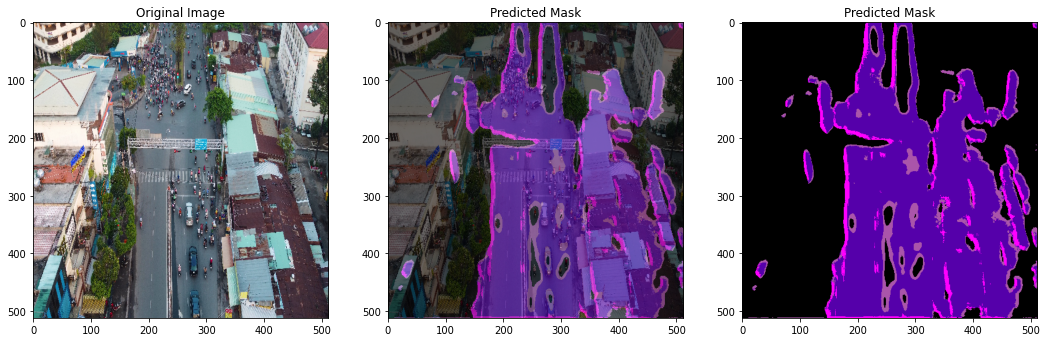

Predicting time: 0.0786440000000006  s
(512, 512, 3)


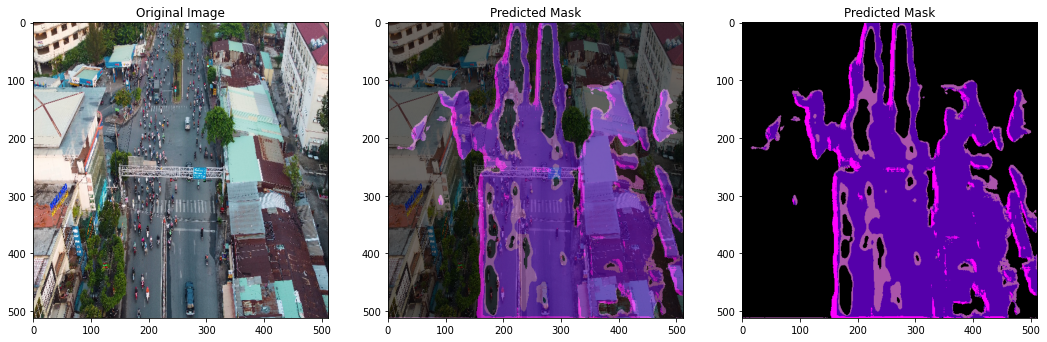

Predicting time: 0.08316400000000002  s
(512, 512, 3)


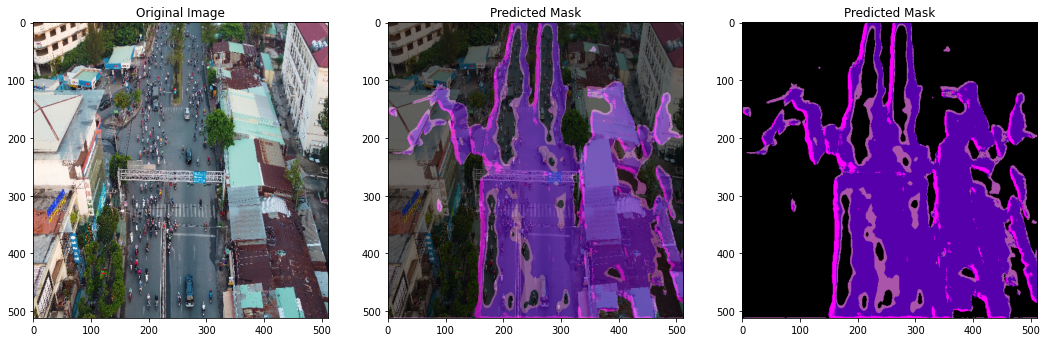

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/dataset/SGScape_Unet_resnetv2.h5',compile=False)
plot_prediction(test_path[0:3],colormap,model=model)

## Test for Inception model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


Predicting time: 3.3045860000000022  s
(512, 512, 3)


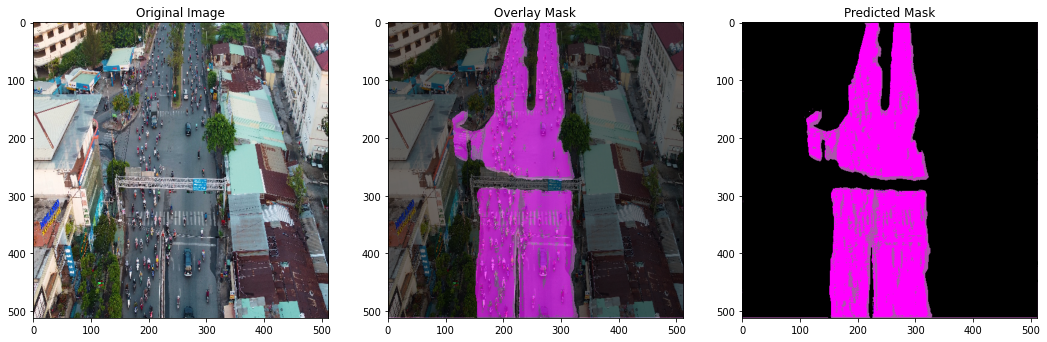

Predicting time: 0.07370200000000082  s
(512, 512, 3)


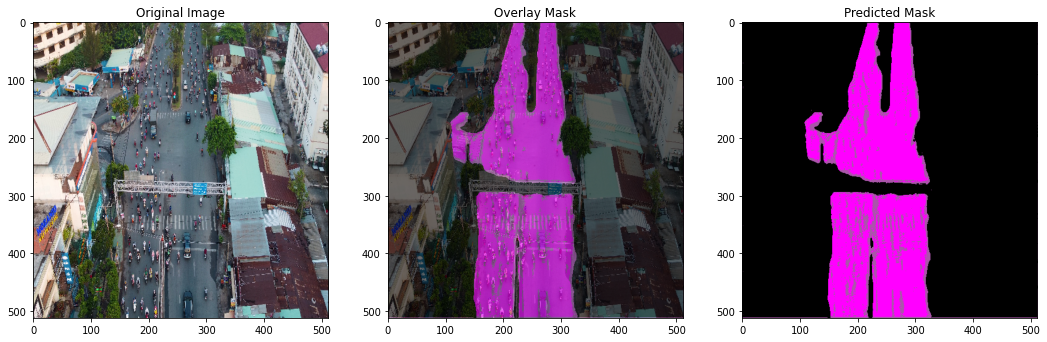

Predicting time: 0.07307699999999784  s
(512, 512, 3)


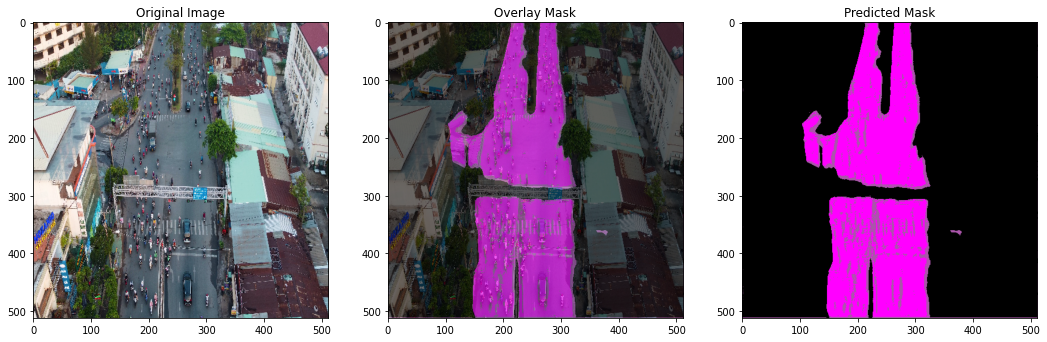

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/dataset/SGScape_Unet_inceptionv2.h5',compile=False)
plot_prediction(test_path[4:7],colormap,model=model)

## Test for ENet